# 实验二：空间拓扑关系运算和生成

## 数据类型定义

In [1]:
from math import atan2, pi
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd

class Node:
    def __init__(self, x, y, idx=None):
        self.x = float(x)
        self.y = float(y)
        self.idx = idx

    def __repr__(self):
        return f"Node({self.idx},{self.x},{self.y})"

class Edge:
    def __init__(self, a: Node, b: Node, idx=None):
        self.a = a
        self.b = b
        self.idx = idx

    def __repr__(self):
        return f"Edge({self.idx},{self.a.idx}->{self.b.idx})"



## 算法实现

In [2]:
def polygon_area(polygon):
    """返回有向面积（首尾点相同）"""
    area = 0
    n = len(polygon)
    for i in range(n - 1):
        area += polygon[i].x * polygon[i + 1].y
        area -= polygon[i].y * polygon[i + 1].x
    return area / 2

def angle_from(a: Node, b: Node):
    return atan2(b.y - a.y, b.x - a.x)

def normalize_angle(a):
    # map to (-pi, pi]
    while a <= -pi:
        a += 2*pi
    while a > pi:
        a -= 2*pi
    return a

def build_topology(nodes, edges):
    """
    输入：nodes: list of Node, edges: list of Edge (undirected)
    输出：polygons (list of list of Node in order, closed),
            relation tables: edge->nodes, node->edges, polygon->edges,
            left_face_of_halfedge: dict((u_idx,v_idx) -> poly_id)
    算法：为每个结点按逆时针排序邻居；以每个有向半边为起点，若未访问则沿着“在顶点上选择紧邻 v->u 之前的边（逆时针上一个）”来跟踪面。
    """
    # index nodes and edges
    for i,n in enumerate(nodes):
        n.idx = i
    for i,e in enumerate(edges):
        e.idx = i

    # build adjacency: node_idx -> list of neighbor idx sorted CCW
    nbrs = defaultdict(list)
    # mapping edge key (min,max) -> edge idx
    undirected_edge_map = {}
    for e in edges:
        u = e.a.idx
        v = e.b.idx
        nbrs[u].append(v)
        nbrs[v].append(u)
        key = tuple(sorted((u,v)))
        undirected_edge_map[key] = e.idx

    # sort neighbor lists CCW by angle from node to neighbor
    for u, lst in list(nbrs.items()):
        unique = list(dict.fromkeys(lst))  # keep order remove dup
        unique.sort(key=lambda w: atan2(nodes[w].y - nodes[u].y, nodes[w].x - nodes[u].x))
        nbrs[u] = unique

    # build set of all directed half-edges
    halfedges = set()
    for u, lst in nbrs.items():
        for v in lst:
            halfedges.add((u,v))

    visited = set()
    polygons = []
    poly_edge_list = []  # list of undirected edge idx for each polygon
    halfedge_left_face = {}  # (u,v) -> polygon id on left of directed half-edge

    for he in list(halfedges):
        if he in visited:
            continue
        start = he
        u, v = start
        ring = [u, v]
        visited.add((u,v))
        curr = (u, v)
        # iterate until we return to start
        while True:
            a, b = curr
            # at vertex b, find index of neighbor a in its CCW list
            nbr_list = nbrs[b]
            if a not in nbr_list:
                # should not happen in well-formed input
                break
            idx = nbr_list.index(a)
            # choose the previous neighbor in CCW order (i.e., clockwise relative to the incoming)
            next_idx = (idx - 1) % len(nbr_list)
            w = nbr_list[next_idx]
            next_he = (b, w)
            if next_he in visited:
                # if we've seen the half-edge, but haven't closed to start, we might still continue until reach start
                pass
            visited.add(next_he)
            ring.append(w)
            curr = next_he
            if curr == start:
                break

        # close ring: ensure first == last
        if ring[0] != ring[-1]:
            ring.append(ring[0])

        # convert to Node list
        poly_nodes = [nodes[i] for i in ring]
        area = polygon_area(poly_nodes)
        # ignore degenerate or zero-area cycles
        if abs(area) < 1e-9 or len(poly_nodes) < 4:
            # still mark half-edges visited (already done)
            continue

        poly_id = len(polygons)
        polygons.append(poly_nodes)

        # collect undirected edges used by this polygon
        used_edges = []
        # for each consecutive pair (u->v) in ring[:-1]
        for i in range(len(ring)-1):
            a = ring[i]
            b = ring[i+1]
            key = tuple(sorted((a,b)))
            eidx = undirected_edge_map.get(key)
            if eidx is not None and eidx not in used_edges:
                used_edges.append(eidx)
            # record that this polygon is to the left of directed half-edge (a->b)
            halfedge_left_face[(a,b)] = poly_id

        poly_edge_list.append(used_edges)

    # build relation tables
    edge_node_table = {e.idx: (e.a.idx, e.b.idx) for e in edges}
    node_edge_table = defaultdict(list)
    for e in edges:
        node_edge_table[e.a.idx].append(e.idx)
        node_edge_table[e.b.idx].append(e.idx)

    # for each undirected edge, determine left and right polygon IDs if any
    edge_lr = {}
    for e in edges:
        u = e.a.idx
        v = e.b.idx
        left_of_u_v = halfedge_left_face.get((u,v))
        left_of_v_u = halfedge_left_face.get((v,u))
        # If polygon is on left of (u->v), then that polygon is right of (v->u)
        edge_lr[e.idx] = {'left_u_v': left_of_u_v, 'left_v_u': left_of_v_u}

    return {
        'polygons': polygons,
        'poly_edges': poly_edge_list,
        'edge_node': edge_node_table,
        'node_edges': dict(node_edge_table),
        'halfedge_left_face': halfedge_left_face,
        'edge_lr': edge_lr,
        'nodes': nodes,
        'edges': edges,
    }

发现多边形数量: 6

多边形表:


,Polygon ID,Node Indices,Coordinates,Area
0,0,"[4, 0, 3, 2, 11, 12, 13, 2, 6, 1, 4, 0, 4]","[(1.0, 0.0), (0.0, 0.0), (0.0, 2.0), (2.0, 2.0...",-5.0
1,1,"[5, 4, 1, 6, 5, 4, 5]","[(1.0, 1.0), (1.0, 0.0), (2.0, 0.0), (2.0, 1.0...",1.0
2,2,"[11, 2, 13, 12, 11, 2, 11]","[(2.0, 3.0), (2.0, 2.0), (3.0, 2.0), (3.0, 3.0...",1.0
3,3,"[8, 9, 10, 7, 8, 9, 8]","[(1.5, 0.5), (1.5, 1.5), (0.5, 1.5), (0.5, 0.5...",1.0
4,4,"[9, 8, 7, 10, 9, 8, 9]","[(1.5, 1.5), (1.5, 0.5), (0.5, 0.5), (0.5, 1.5...",-1.0
5,5,"[6, 2, 3, 0, 4, 5, 6, 2, 6]","[(2.0, 1.0), (2.0, 2.0), (0.0, 2.0), (0.0, 0.0...",3.0



弧段-结点表:


,Edge ID,Node A,Node B
0,0,4,1
1,1,1,6
2,2,2,3
3,3,3,0
4,4,0,4
5,5,4,5
6,6,5,6
7,7,6,2
8,8,7,8
9,9,8,9



结点-弧段表:


,Node ID,Connected Edges
0,4,"[0, 4, 5]"
1,1,"[0, 1]"
2,6,"[1, 6, 7]"
3,2,"[2, 7, 12, 15]"
4,3,"[2, 3]"
5,0,"[3, 4]"
6,5,"[5, 6]"
7,7,"[8, 11]"
8,8,"[8, 9]"
9,9,"[9, 10]"



多边形-弧段表:


,Polygon ID,Edge IDs
0,0,"[4, 3, 2, 12, 13, 14, 15, 7, 1, 0]"
1,1,"[5, 0, 1, 6]"
2,2,"[12, 15, 14, 13]"
3,3,"[9, 10, 11, 8]"
4,4,"[9, 8, 11, 10]"
5,5,"[7, 2, 3, 4, 5, 6]"



弧段左右面信息:


,Edge ID,Left of (u->v),Left of (v->u)
0,0,1,0
1,1,1,0
2,2,5,0
3,3,5,0
4,4,5,0
5,5,5,1
6,6,5,1
7,7,5,5
8,8,3,4
9,9,4,4


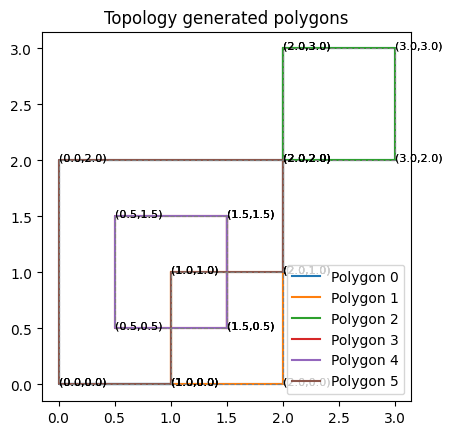

In [3]:
nodes = [Node(0, 0), Node(2, 0), Node(2, 2), Node(0, 2), Node(1, 0), Node(1, 1), Node(2, 1), Node(0.5, 0.5), Node(1.5, 0.5), Node(1.5, 1.5), Node(0.5, 1.5), Node(2, 3), Node(3, 3), Node(3, 2)]
edges = [
    Edge(nodes[4], nodes[1]), Edge(nodes[1], nodes[6]), Edge(nodes[2], nodes[3]), Edge(nodes[3], nodes[0]), Edge(nodes[0], nodes[4]),
    Edge(nodes[4], nodes[5]), Edge(nodes[5], nodes[6]), Edge(nodes[6], nodes[2]), Edge(nodes[7], nodes[8]), Edge(nodes[8], nodes[9]),
    Edge(nodes[9], nodes[10]), Edge(nodes[10], nodes[7]), Edge(nodes[2], nodes[11]), Edge(nodes[11], nodes[12]), Edge(nodes[12], nodes[13]), Edge(nodes[13], nodes[2])
]

topo = build_topology(nodes, edges)


print("发现多边形数量:", len(topo['polygons']))

# Polygon table
poly_data = []
for i, poly in enumerate(topo['polygons']):
    coords = [(p.x, p.y) for p in poly]
    poly_data.append({
        'Polygon ID': i,
        'Node Indices': [n.idx for n in poly],
        'Coordinates': coords,
        'Area': round(polygon_area(poly), 3)
    })
df_polygons = pd.DataFrame(poly_data)
print("\n多边形表:")
display(df_polygons)

# Edge-Node table
edge_node_data = [{'Edge ID': k, 'Node A': v[0], 'Node B': v[1]} for k, v in topo['edge_node'].items()]
df_edge_node = pd.DataFrame(edge_node_data)
print("\n弧段-结点表:")
display(df_edge_node)

# Node-Edge table
node_edge_data = [{'Node ID': k, 'Connected Edges': v} for k, v in topo['node_edges'].items()]
df_node_edge = pd.DataFrame(node_edge_data)
print("\n结点-弧段表:")
display(df_node_edge)

# Polygon-Edge table
poly_edge_data = [{'Polygon ID': i, 'Edge IDs': v} for i, v in enumerate(topo['poly_edges'])]
df_poly_edge = pd.DataFrame(poly_edge_data)
print("\n多边形-弧段表:")
display(df_poly_edge)

# Edge Left-Right face table
edge_lr_data = [{'Edge ID': k, 'Left of (u->v)': v['left_u_v'], 'Left of (v->u)': v['left_v_u']} for k, v in topo['edge_lr'].items()]
df_edge_lr = pd.DataFrame(edge_lr_data)
print("\n弧段左右面信息:")
display(df_edge_lr)

fig, ax = plt.subplots()
colors = ['C0','C1','C2','C3','C4','C5']
for i, poly in enumerate(topo['polygons']):
    xs = [p.x for p in poly]
    ys = [p.y for p in poly]
    ax.plot(xs, ys, colors[i%len(colors)], label=f'Polygon {i}')
    # 标注结点坐标
    for p in poly[:-1]:
        ax.text(p.x, p.y, f"({p.x},{p.y})", fontsize=8)

# 绘制所有弧段
for e in edges:
    ax.plot([e.a.x, e.b.x], [e.a.y, e.b.y], color='gray', linestyle='--', linewidth=0.8)

ax.set_aspect('equal', 'box')
ax.legend()
ax.set_title('Topology generated polygons')
plt.show()

貌似我怎么调整代码生成出来都是六个捏？不管啦。

## 简答题

> 如何在生成多边形的同时，记录弧段的左右多边形信息？

通过结合左转和右转算法实现弧段左右多边形的记录。

### 核心思路

左转算法（逆时针遍历）生成的多边形位于弧段的左侧，右转算法（顺时针遍历）生成的多边形位于弧段的右侧。

### 实现步骤
1. 初始化：为每条边创建 `left_polygon` 和 `right_polygon` 属性，初始值为 `None`
2. 左转遍历：从每条边出发，使用左转算法（选择逆时针方向角度最小的边）生成多边形。生成多边形后，将该多边形ID记录到路径中所有边的 `left_polygon` 属性
3. 右转遍历：从每条边出发，使用右转算法（选择顺时针方向角度最小的边）生成多边形。生成多边形后，将该多边形ID记录到路径中所有边的 `right_polygon` 属性
4. 去重处理：多个起始边可能生成相同的多边形，需要通过标准化节点序列进行去重
